In [53]:
!pip install graphviz
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [54]:
def f(x):
    return 3*x**2 - 4*x + 5

In [55]:
f(3)

20

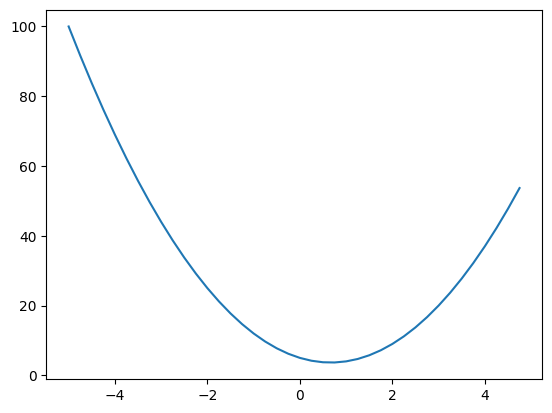

In [56]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

# 求导

In [57]:
# 计算x=3时的导数dy/dx
# dy/dx表示y如何被x影响，例如dy/dx=14，当x增加h时，y会增加14h
x = 3
h = 0.00001

(f(x+h)-f(x)) / h

14.00003000000538

In [58]:
a = 2
b = -3.0
c = 10

d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)

# 计算c=10时的导数dd/dc
print('slope', (d2-d1)/h)

# 也可以通过求导公式计算dd/dc
# 把c当做变量，把a、c当做常量：d = 2 * -3 + c
# 根据求导公式，dd/dc = 1

d1 4.0
d2 4.00001
slope 0.9999999999621422


# 链式法则

In [59]:
a = 2
b = -3
c = 10
e = a*b
d = e+c
f = -2
L = d*f
L

-8

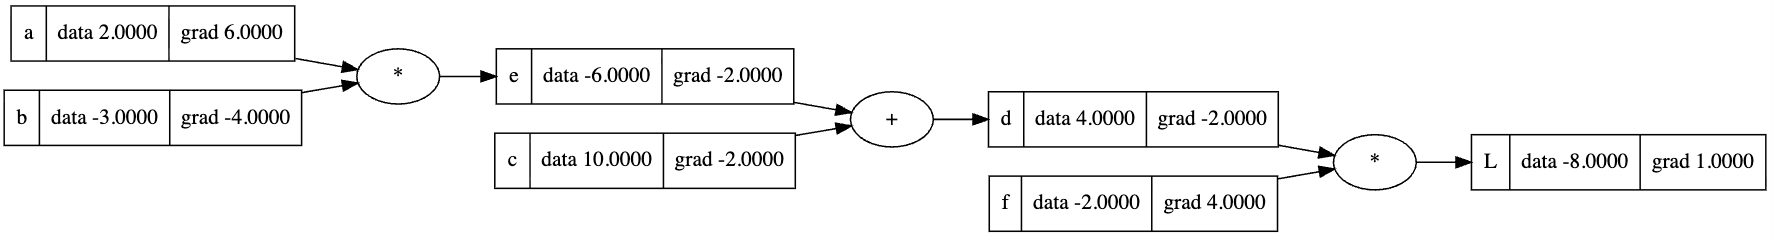

In [60]:
# 计算向量节点的导数
# dL/dd：L = d*f = d * -2，dL/dd = -2
dL_dd = -2
# dd/de：d = e+c = e + 10，dd/de = 1
dd_de = 1
# de/da：e = a*b = a * -3，dd/de = -3
de_da = -3

# 根据链式法则计算dL/da
dL_da = dL_dd * dd_de * de_da
print(dL_da)

6


# 实现自动求导

In [61]:
class Value:
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self.grad = 0
        # c = a + b，a和b为children
        self.children = children
        self._prev = set(children)
        # 根节点不需要backward
        self._backward = lambda: None
        # 仅为了方便展示
        self._op = op 
        self.label = label
        
    # print输出的内容
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # 支持 int * Value
    def __rmul__(self, other): # other * self
        return self * other
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __neg__(self): # -self
        return self * -1
    
    def __radd__(self, other): # other + self
        return self + other
    
    # 定义+操作
    # a + b = a.__add__(b)
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # 前向传播更新父节点的值，保存节点关系
        out = Value(self.data + other.data, (self, other), '+')
        
        # 反向传播更新子节点的梯度
        def _backward():
            # 为什么+=？梯度累计，一个值可能被多次计算
            # 为什么乘1？y = x + 1, x的导数为1
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
        
    # 定义+操作
    # a + b = a.__add__(b)
    def __mul__(self, other):
        # 支持 Value * int
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # 为什么乘other.data？y = x * 2, x的导数为2
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        # tanh(x) = (e^2x - 1) / (e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # y = tanh(x)，dy/dx = 1 - y**2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out
    
    # 根节点调用
    def backward(self):
        # 保证前向/反向传播时节点不重复计算
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # 根节点的grad无意义，为了正确反向传播，设置为1
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [62]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.backward()

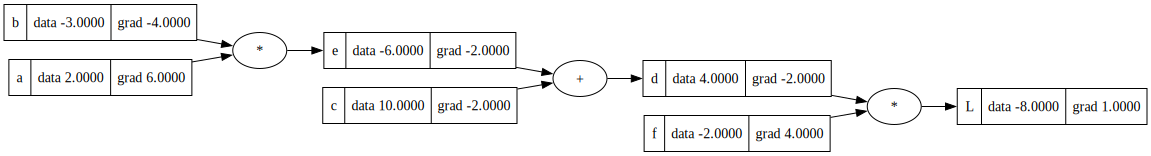

In [63]:
from utils import draw_dot

draw_dot(L)

In [64]:
# 使用pytorch实现相同的计算
import torch

a = torch.Tensor([2]).double() ; a.requires_grad = True
b = torch.Tensor([-3]).double(); b.requires_grad = True
c = torch.Tensor([10]).double(); c.requires_grad = True
f = torch.Tensor([-2]).double(); f.requires_grad = True
e = a*b
d = e+c
L = f*d
print(L.data.item())

L.backward()

print('---grad---')
print('a', a.grad.item())
print('b', b.grad.item())
print('c', c.grad.item())
print('f', f.grad.item())

-8.0
---grad---
a 6.0
b -4.0
c -2.0
f 4.0


# 神经网络

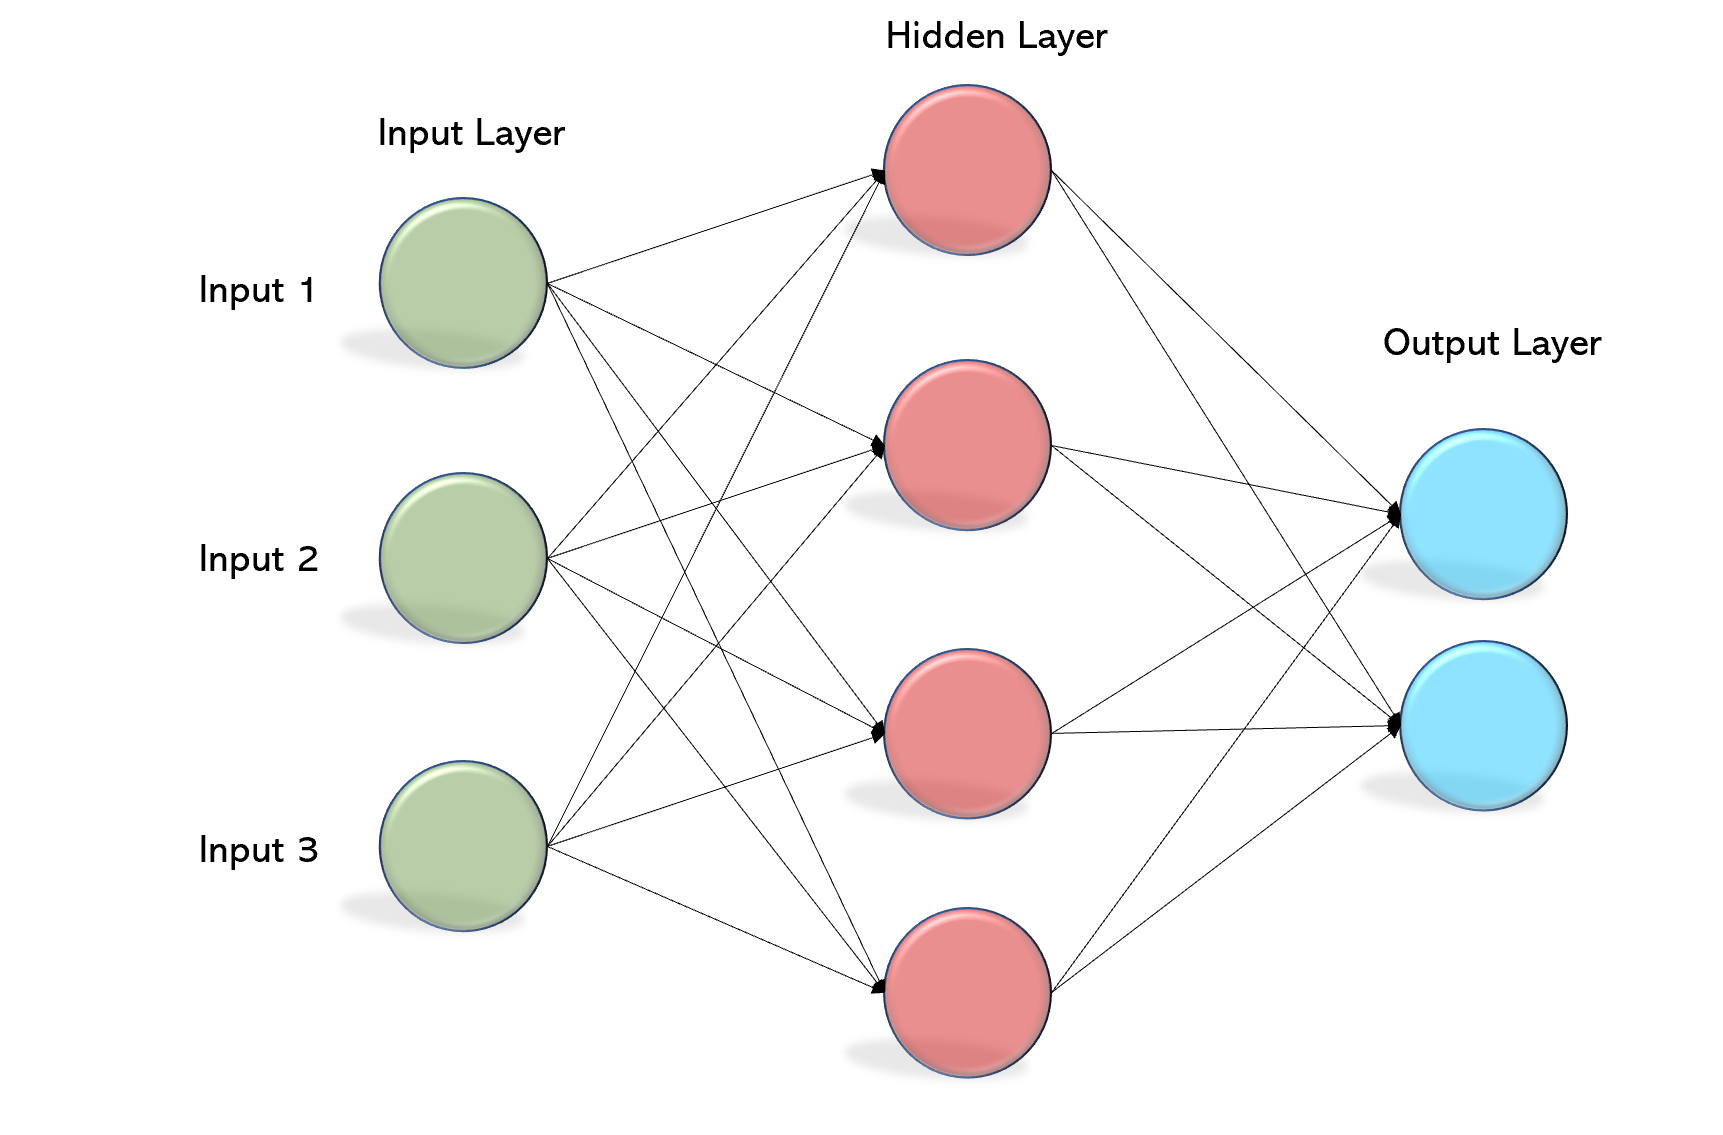

In [65]:
import random

# 神经元
# active(WX+b)
class Neuron:
    def __init__(self, nin):
        self.W = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # x = [x1, x2], w = [w1, w2]
        # act = x1*w1 + x2*w2 + b
        act = sum((w*x for w, x in zip(self.W, x)), self.b)
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.W + [self.b]

# 神经网络层，本质上是多个神经元
class Layer:
    # 定义Neuron的维度和Neuron的数量
    # 本层Neuron的数量是下一层Neuron的维度
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# 多个神经网络层
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [1, 2, 4]
mlp = MLP(3, [4, 4, 1])
out = mlp(x)
print(out)

Value(data=-0.6177729563374378)


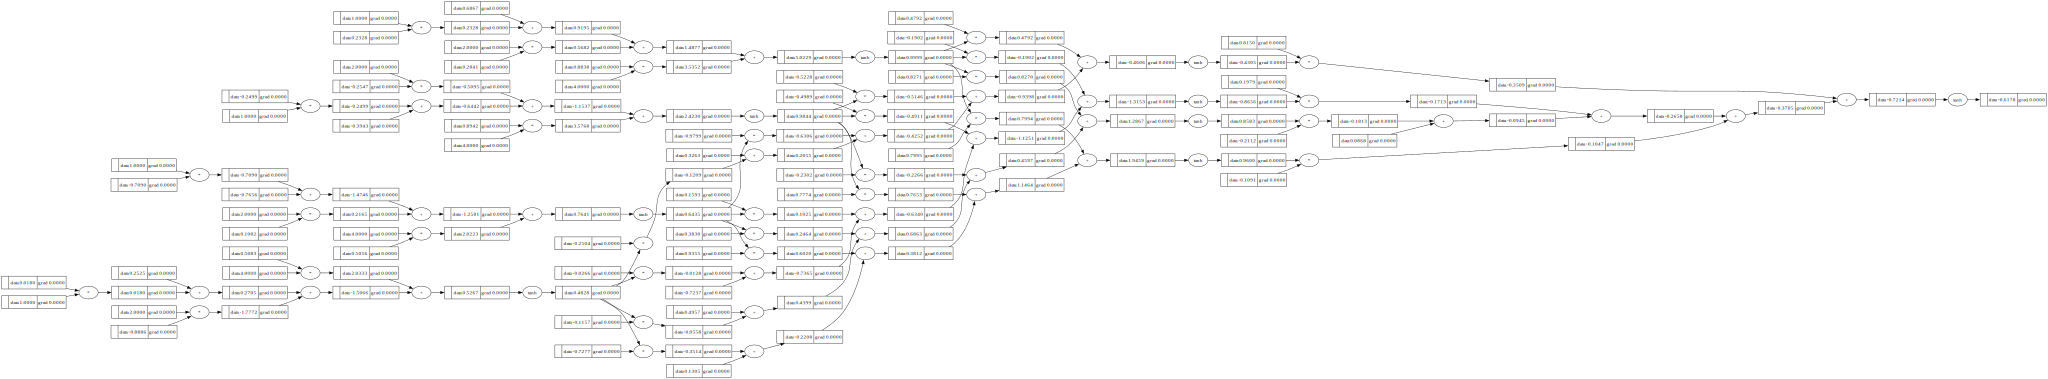

In [66]:
draw_dot(out)

# 训练一个二分类神经网络

In [67]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [-1, 1, 1, -1]


In [69]:
for i in range(20):
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)*(yout - ygt) for ygt, yout in zip(ys, ypred)])
    print('loss', loss.data)
    
    for p in mlp.parameters():
        p.grad = 0
        
    loss.backward()
    
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
        

loss 3.990218971195444
loss 3.8844613477941428
loss 3.7601967005503676
loss 3.589401443015478
loss 3.328446025552203
loss 2.9071503528393703
loss 2.2671891386697793
loss 1.5378455592124012
loss 0.9785053342591169
loss 0.6340028484180565
loss 0.43499937225179297
loss 0.317964582864638
loss 0.2451391630994884
loss 0.19695369402086788
loss 0.16331058478295785
loss 0.1387581795537088
loss 0.12018390352256275
loss 0.10571346033194104
loss 0.09416378505256773
loss 0.08475711685137122


In [70]:
[mlp(x) for x in xs]

[Value(data=-0.8547579451735833),
 Value(data=0.9011842249941063),
 Value(data=0.8435326092165081),
 Value(data=-0.852955458715648)]